## Desafío N.3 - Proceso Batch a la Nube (Azure)

### Objetivo

Crear un proceso batch que migre los archivos **.parquet** generados de manera local a un contenerdos en la nube ("Azure Blob Storage").

### Tecnologias empleadas

| Librería / Módulo                    | Propósito                                           |  Descripción                                                                                                                                                                           |
| ------------------------------------ | --------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **azure.storage.blob**               | Conexión a Azure Blob Storage                       | Permite interactuar con contenedores y blobs en Azure. Se utiliza `BlobServiceClient` para crear contenedores y subir los archivos `.parquet` generados al almacenamiento en la nube. |
| **pathlib.Path**                     | Manejar rutas de archivos                           | Simplifica la gestión de rutas locales (`data/`) de forma compatible entre sistemas operativos. Se usa para iterar sobre los archivos `.parquet` en la carpeta de datos.              |
| **os**                               | Interactuar con el sistema operativo                | Se emplea para acceder a las variables de entorno (`AZURE_STORAGE_CONNECTION_STRING`, `AZURE_CONTAINER`, `SUPABASE_URL`, `SUPABASE_KEY`, etc.) almacenadas de forma segura.           |
| **dotenv (load_dotenv)**             | Cargar variables de entorno desde un archivo `.env` | Permite cargar automáticamente credenciales y configuraciones sensibles sin incluirlas directamente en el código fuente.                                                              |
| **pandas**                           | Manipulación y análisis de datos                    | Se usa para leer los archivos `.parquet` (`employees.parquet`, `jobs.parquet`), limpiar y transformar los datos antes de su carga a la base de datos.                                 |
| **psycopg2**                         | Conexión a bases de datos PostgreSQL                | Biblioteca nativa para interactuar con bases de datos PostgreSQL. En este proyecto, permite conectarse a **Supabase**, que usa PostgreSQL como motor principal.                       |
| **psycopg2.extras (execute_values)** | Inserción eficiente de datos                        | Optimiza la carga masiva de registros desde DataFrames hacia tablas PostgreSQL (Supabase) en una sola instrucción SQL, reduciendo el tiempo de inserción.                             |



### Ejecución

El desarrollo del batch lleva el siguiente proceso: Local /data/*.parquet   -> Azure Blob Storage (Raw Layer / Landing Zone) & Supabase(postgreSQL) -> Desafío n.4. Para su ejecución se desarrollaron los pasos de:

1. **Varaibles de entorno**
    
    Con **dotev** se mantienen las credenciales privadas y seguras evitando su vulnerabilidad en el codigo.
    ```python
    from azure.storage.blob import BlobServiceClient
    from pathlib import Path
    import os
    from dotenv import load_dotenv
    import psycopg2
    from psycopg2.extras import execute_values
    import pandas as pd



    # Cargar variables desde archivo .env
    load_dotenv()

    # Recuperar valores
    CONN_STR = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
    CONTAINER = os.getenv("AZURE_CONTAINER")
    DATA_DIR = Path("data")
    ```
    **Nota**: El archivo .env tiene la forma:

    AZURE_STORAGE_CONNECTION_STRING=DefaultEndpointsProtocol=...

    AZURE_CONTAINER=synthetic-data


2. **Conexión Azure Blob Storage**
    
    Se crea la conexión con Azure Blob Storage
    ```python
    from azure.storage.blob import BlobServiceClient

    # Crear cliente de servicio
    blob_service_client = BlobServiceClient.from_connection_string(CONN_STR)
    ```

3. **Creación de contenedores**
    
    Se crea para la cargar los archivos. Si ya existe o se genera error devuelve mensaje.  
    ```python
    try:
        blob_service_client.create_container(CONTAINER)
        print(f"✅ Contenedor '{CONTAINER}' creado")
    except Exception as e:
        print(f"⚠️ Contenedor '{CONTAINER}' ya existe o error: {e}")
    ```


3. **Carga de archivos**
    
    Se recorre la carpeta **data** para cargar o sobrescribir todos los archivos **.parquet**.  
```python
  for file_path in DATA_DIR.glob("*.parquet"):
    blob_client = blob_service_client.get_blob_client(container=CONTAINER, blob=file_path.name)
    with open(file_path, "rb") as data:
        blob_client.upload_blob(data, overwrite=True)
    print(f"✅ Subido {file_path.name} a Azure Blob Storage")
```


4. **Conexión segura a Supabase**
    
    Se establecen las credenciales de conexión usando variables de entorno.  
```python
    SUPABASE_HOST = os.getenv("SUPABASE_HOST")
    SUPABASE_DB = os.getenv("SUPABASE_DB")
    SUPABASE_USER = os.getenv("SUPABASE_USER")
    SUPABASE_PASSWORD = os.getenv("SUPABASE_PASSWORD")
    SUPABASE_PORT = os.getenv("SUPABASE_PORT", 5432)

    conn = psycopg2.connect(
        host=SUPABASE_HOST,
        dbname=SUPABASE_DB,
        user=SUPABASE_USER,
        password=SUPABASE_PASSWORD,
        port=SUPABASE_PORT
    )
    cur = conn.cursor()
    print("✅ Conectado a Supabase")

```


5. **Carga de tabla**
    
    Se crea con estructura definida, y se insertan los datos desde los archivos correspondientes, en este caso **deparments.parquet**.  
```python
   df_departamentos = pd.read_parquet("data/departments.parquet")

    cur.execute("""
    DROP TABLE IF EXISTS departamentos CASCADE;
    CREATE TABLE departamentos (
        department_id SERIAL PRIMARY KEY,
        department_name TEXT,
        location TEXT
    );
    """)

    execute_values(
        cur,
        "INSERT INTO departamentos (department_id, department_name, location) VALUES %s",
        df_departamentos.values.tolist()
    )
    print(f"✅ Tabla 'departamentos' cargada ({len(df_departamentos)} filas)")


```


6. **Creación de  llaves foráneas y cierre de conexión**
    
    Se crea llaves foraneas para asegurar la integridad referencial mediante claves foráneas:.  
```python
    cur.execute("""
    DROP TABLE IF EXISTS empleados CASCADE;
    CREATE TABLE empleados (
        employee_id SERIAL PRIMARY KEY,
        first_name TEXT,
        last_name TEXT,
        email TEXT,
        phone_number TEXT,
        department_id INT REFERENCES departamentos(department_id),
        job_id INT REFERENCES puestos(job_id),
        salary NUMERIC,
        hire_date DATE
    );
    """)

    conn.commit()
    cur.close()
    conn.close()
    print("🔒 Carga finalizada correctamente con relaciones entre tablas")

```


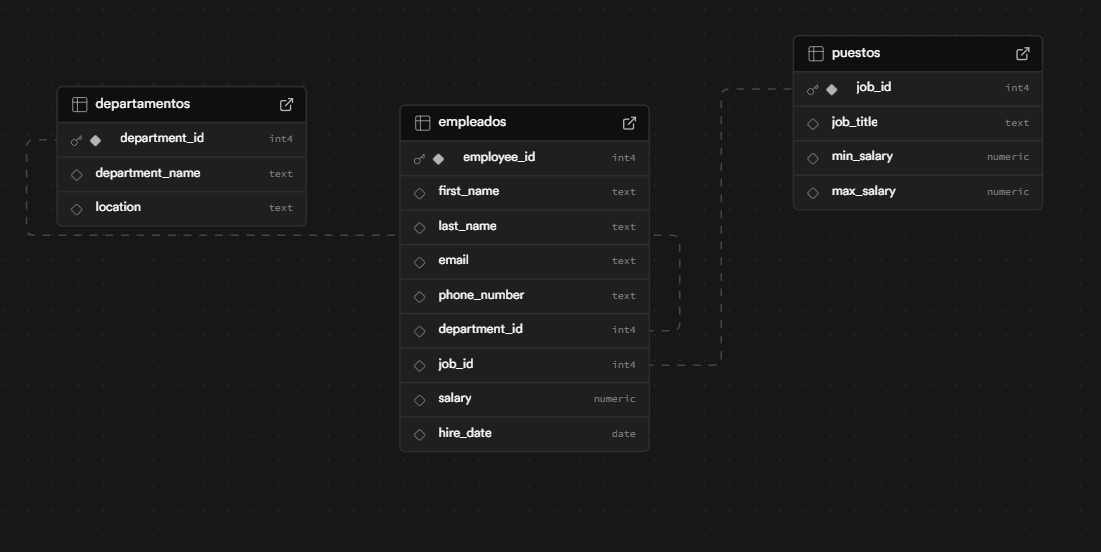